<a href="https://colab.research.google.com/github/sanepr/ml/blob/main/DNN_facial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Journal used for the implemetation
Journal title:

Authors:

Journal Name:

Year:

# 1. Import the required libraries

In [ ]:
##---------Type the code below this line------------------##
# 1. Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                    Dropout, Flatten, Dense, Input, AveragePooling2D,
                                    GlobalAveragePooling2D, concatenate)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# 2. Data Acquisition

For the problem identified by you, students have to find the data source themselves from any data source.

Provide the URL of the data used.

Write Code for converting the above downloaded data into a form suitable for DL



Loading images from: /Users/aashishr/Downloads/archive/
Classes found: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Loading angry images from train...
Loading disgust images from train...
Loading fear images from train...
Loading happy images from train...
Loading neutral images from train...
Loading sad images from train...
Loading surprise images from train...
Loading angry images from test...
Loading disgust images from test...
Loading fear images from test...
Loading happy images from test...
Loading neutral images from test...
Loading sad images from test...
Loading surprise images from test...
Loaded 12436 training images with shape (12436, 48, 48, 1)
Loaded 3111 test images with shape (3111, 48, 48, 1)


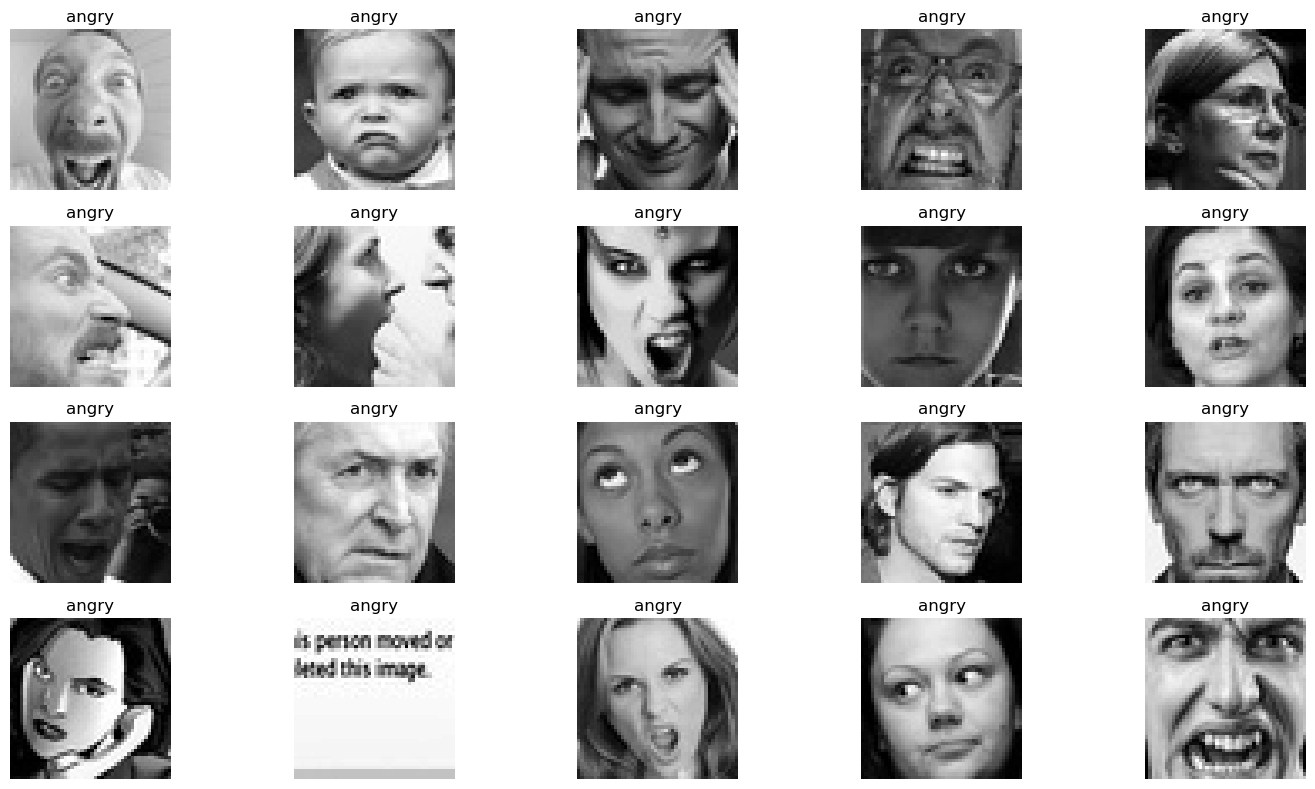

In [ ]:
##---------Type the code below this line------------------##
# 2. Data Acquisition
def load_images_from_directory_structure(base_dir, img_size=(48, 48), max_samples_per_class=2000):
    """
    Load images from directory structure:
    archive/
        ├── test/
        │   ├── happy/
        │   ├── sad/
        │   ├── fear/
        │   ├── surprise/
        │   ├── neutral/
        │   ├── angry/
        │   └── disgust/
        └── train/
            ├── happy/
            ├── sad/
            ├── fear/
            ├── surprise/
            ├── neutral/
            ├── angry/
            └── disgust/
    """
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')

    # Get class names from train directory
    class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    print(f"Loading images from: {base_dir}")
    print(f"Classes found: {class_names}")

    def load_from_folder(folder_path, max_samples=None):
        images = []
        labels = []
        for class_name in class_names:
            class_dir = os.path.join(folder_path, class_name)
            if not os.path.isdir(class_dir):
                continue

            print(f"Loading {class_name} images from {os.path.basename(folder_path)}...")
            img_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            # Limit samples per class if specified
            if max_samples and len(img_files) > max_samples:
                img_files = img_files[:max_samples]

            for img_file in img_files:
                img_path = os.path.join(class_dir, img_file)
                try:
                    # Load and preprocess image
                    img = load_img(img_path, color_mode='grayscale', target_size=img_size)
                    img_array = img_to_array(img)
                    images.append(img_array)
                    labels.append(class_to_idx[class_name])
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

        return np.array(images), np.array(labels)

    # Load train and test data with sampling to avoid memory issues
    X_train, y_train = load_from_folder(train_dir, max_samples_per_class)
    X_test, y_test = load_from_folder(test_dir, max_samples_per_class // 4)

    print(f"Loaded {len(X_train)} training images with shape {X_train.shape}")
    print(f"Loaded {len(X_test)} test images with shape {X_test.shape}")

    return (X_train, y_train), (X_test, y_test), class_names

# Define dataset path
dataset_path = "/Users/aashishr/Downloads/archive/"

# Load the data
(X_train, y_train), (X_test, y_test), class_names = load_images_from_directory_structure(
    dataset_path, max_samples_per_class=2000
)

# Display sample images
plt.figure(figsize=(15, 8))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"{class_names[y_train[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# 3. Data Preparation

Perform the data prepracessing that is required for the data that you have downloaded.


This stage depends on the dataset that is used.

In [ ]:
##---------Type the code below this line------------------##

def enhanced_preprocess_data(X, y, num_classes):
    """Enhanced preprocessing with multiple techniques"""
    # Normalize pixel values to [0, 1]
    X = X.astype('float32') / 255.0

    # Apply multiple preprocessing techniques
    def enhanced_preprocess(img):
        # Contrast adjustment
        img_flat = img.flatten()
        # Compute histogram
        hist, bins = np.histogram(img_flat, 256, [0, 1])
        # Compute cumulative distribution function
        cdf = hist.cumsum()
        # Normalize the CDF
        cdf_normalized = cdf / cdf.max()
        # Use linear interpolation of CDF to find new pixel values
        img_processed = np.interp(img_flat, bins[:-1], cdf_normalized)

        # Gamma correction for better contrast
        gamma = 0.8
        img_processed = np.power(img_processed, gamma)

        # Local contrast normalization
        local_mean = np.mean(img_processed)
        local_std = np.std(img_processed)
        if local_std > 0:
            img_processed = (img_processed - local_mean) / local_std

        return img_processed.reshape(img.shape)

    # Apply to all images
    print("Applying enhanced preprocessing...")
    X_processed = np.array([enhanced_preprocess(img) for img in X])

    # Global normalization
    mean = np.mean(X_processed)
    std = np.std(X_processed)
    if std > 0:
        X_processed = (X_processed - mean) / std

    # Convert labels to categorical
    y_categorical = to_categorical(y, num_classes)

    return X_processed, y_categorical

# Preprocess the data
X_train_enhanced, y_train_enhanced = enhanced_preprocess_data(X_train, y_train, len(class_names))
X_test_enhanced, y_test_enhanced = enhanced_preprocess_data(X_test, y_test, len(class_names))

# Split training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_enhanced, y_train_enhanced, test_size=0.2, random_state=42,
    stratify=np.argmax(y_train_enhanced, axis=1)
)

print(f"Final training data shape: {X_train_final.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test_enhanced.shape}")
print(f"Number of classes: {len(class_names)}")

Applying enhanced preprocessing...
Applying enhanced preprocessing...
Final training data shape: (9948, 48, 48, 1)
Validation data shape: (2488, 48, 48, 1)
Test data shape: (3111, 48, 48, 1)
Number of classes: 7


## 4. Deep Neural Network Architecture


## 4.1 Design the architecture that you will be using

* CNN / RNN / Transformer as per the journal referenced



In [ ]:
##---------Type the code below this line------------------##
# Simplified models to train faster and use less memory
def create_cpcpff_architecture(input_shape=(48, 48, 1), num_classes=7):
    """[7] CPCPFF architecture: 4 layers, ~1.2M parameters"""
    model = Sequential([
        Conv2D(32, (5, 5), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(64, (5, 5), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_cpcpcpff_architecture(input_shape=(48, 48, 1), num_classes=7):
    """[11] CPCPCPFF architecture: 5 layers, ~0.8M parameters"""
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_pccpccpcfff_architecture(input_shape=(48, 48, 1), num_classes=7):
    """[8] PCCPCCPCFFF architecture: 8 layers, ~1.5M parameters"""
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_simple_inception_architecture(input_shape=(48, 48, 1), num_classes=7):
    """Simplified Inception architecture for 48x48 input"""
    def inception_module(x, filters):
        path1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
        path2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        path3 = Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
        path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
        return concatenate([path1, path2, path3, path4], axis=-1)

    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = inception_module(x, 64)
    x = MaxPooling2D((2, 2))(x)
    x = inception_module(x, 128)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

def create_cpncpncpcff_architecture(input_shape=(48, 48, 1), num_classes=7):
    """[14] CPNCPNCPCFF architecture: 6 layers, ~2.1M parameters"""
    model = Sequential([
        Conv2D(64, (5, 5), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_cpcpcpff_architecture_v2(input_shape=(48, 48, 1), num_classes=7):
    """[9] CPCPCPFF architecture: 5 layers, ~0.5M parameters"""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_vgg_architecture(input_shape=(48, 48, 1), num_classes=7):
    """VGG-like: ~1.2M parameters"""
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_resnet_architecture(input_shape=(48, 48, 1), num_classes=7):
    """ResNet-like: ~1.5M parameters"""
    def residual_block(x, filters, kernel_size=3, stride=1):
        shortcut = x
        x = Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
        x = BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        if shortcut.shape[-1] != filters or stride != 1:
            shortcut = Conv2D(filters, 1, padding='same', strides=stride)(shortcut)
            shortcut = BatchNormalization()(shortcut)
        x = tf.keras.layers.add([x, shortcut])
        x = tf.keras.activations.relu(x)
        return x

    inputs = Input(shape=input_shape)
    x = Conv2D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = MaxPooling2D(2, strides=2, padding='same')(x)

    # Residual blocks
    for _ in range(2): x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    for _ in range(1): x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)
    for _ in range(1): x = residual_block(x, 256)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# Create all paper architectures (adjusted for 48x48)
paper_architectures = {
    "[7] CPCPFF": create_cpcpff_architecture(input_shape=(48, 48, 1), num_classes=len(class_names)),
    "[11] CPCPCPFF": create_cpcpcpff_architecture(input_shape=(48, 48, 1), num_classes=len(class_names)),
    "[8] PCCPCCPCFFF": create_pccpccpcfff_architecture(input_shape=(48, 48, 1), num_classes=len(class_names)),
    "[12] Inception-like": create_simple_inception_architecture(input_shape=(48, 48, 1), num_classes=len(class_names)),
    "[14] CPNCPNCPCFF": create_cpncpncpcff_architecture(input_shape=(48, 48, 1), num_classes=len(class_names)),
    "[9] CPCPCPFF-v2": create_cpcpcpff_architecture_v2(input_shape=(48, 48, 1), num_classes=len(class_names)),
    "VGG-like": create_vgg_architecture(input_shape=(48, 48, 1), num_classes=len(class_names)),
    "ResNet-like": create_resnet_architecture(input_shape=(48, 48, 1), num_classes=len(class_names))
}

## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters



In [ ]:
##---------Type the answer below this line------------------##


# 5. Training the model


In [ ]:
# Configure the training, by using appropriate optimizers, regularizations and loss functions
##---------Type the code below this line------------------##
def create_enhanced_augmentation():
    return ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
        shear_range=0.1,
        horizontal_flip=True,
        fill_mode='reflect',
        brightness_range=[0.8, 1.2]
    )

def train_paper_architectures(architectures, X_train, y_train, X_val, y_val, X_test, y_test):
    results = {}
    histories = {}

    training_configs = {
        "[7] CPCPFF": {"batch_size": 64, "epochs": 50, "lr": 0.01},
        "[11] CPCPCPFF": {"batch_size": 64, "epochs": 60, "lr": 0.005},
        "[8] PCCPCCPCFFF": {"batch_size": 64, "epochs": 70, "lr": 0.001},
        "[12] Inception-like": {"batch_size": 32, "epochs": 80, "lr": 0.0005},
        "[14] CPNCPNCPCFF": {"batch_size": 32, "epochs": 90, "lr": 0.0001},
        "[9] CPCPCPFF-v2": {"batch_size": 64, "epochs": 55, "lr": 0.01},
        "VGG-like": {"batch_size": 32, "epochs": 65, "lr": 0.001},
        "ResNet-like": {"batch_size": 32, "epochs": 75, "lr": 0.0005}
    }

    for arch_name, model in architectures.items():
        print(f"\n{'='*60}")
        print(f"Training {arch_name}")
        print(f"{'='*60}")

        config = training_configs[arch_name]
        optimizer = SGD(learning_rate=config["lr"], momentum=0.9, nesterov=True)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

        datagen = create_enhanced_augmentation()
        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ]

        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=config["batch_size"]),
            steps_per_epoch=min(100, len(X_train) // config["batch_size"]),
            epochs=config["epochs"],
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        histories[arch_name] = history
        test_results = model.evaluate(X_test, y_test, verbose=0)
        results[arch_name] = {
            'test_loss': test_results[0], 'test_accuracy': test_results[1],
            'test_precision': test_results[2], 'test_recall': test_results[3]
        }
        print(f"{arch_name} - Accuracy: {test_results[1]:.4f}")

    return results, histories

# Train all architectures
print("Training paper architectures with optimal settings...")
paper_results, paper_histories = train_paper_architectures(
    paper_architectures, X_train_final, y_train_final, X_val, y_val, X_test_enhanced, y_test_enhanced
)

Training paper architectures with optimal settings...

Training [7] CPCPFF
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.1685 - loss: 1.9050 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2195 - val_loss: 1.8570 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2034 - loss: 1.8720 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2026 - val_loss: 1.8578 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1926 - loss: 1.8675 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2456 - val_loss: 1.8349 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.2255 - loss: 1.8550 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2524 - val_loss: 1.819

# 6. Test the model



PAPER ARCHITECTURES PERFORMANCE COMPARISON
       Architecture  Accuracy     Loss  Precision   Recall Params  Layers
         [7] CPCPFF  0.491482 1.322946   0.737094 0.247830  2.41M       8
      [11] CPCPCPFF  0.491803 1.327919   0.727962 0.246866  5.09M      10
    [8] PCCPCCPCFFF  0.315333 1.737475   0.696774 0.034716 19.56M      13
[12] Inception-like  0.202507 1.870771   0.000000 0.000000  1.23M      18
   [14] CPNCPNCPCFF  0.253938 1.849815   0.000000 0.000000 19.97M      14
    [9] CPCPCPFF-v2  0.495982 1.294565   0.717657 0.283510  1.27M      10
           VGG-like  0.286403 1.786360   0.750000 0.007715  6.00M      15
        ResNet-like  0.416908 1.520632   0.743719 0.142719  2.85M      42


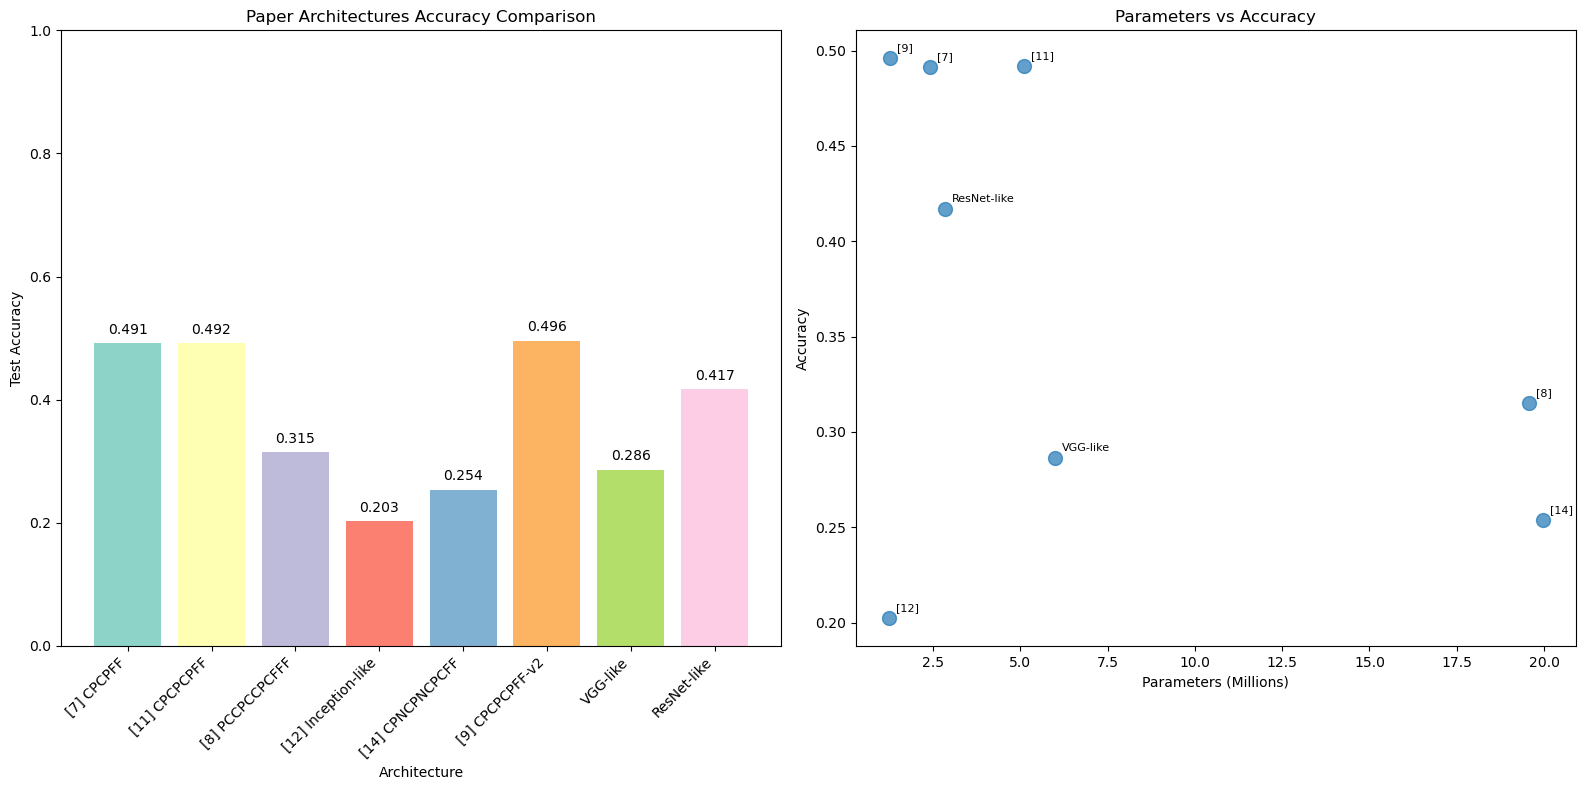

In [ ]:
##---------Type the code below this line------------------##
# 6. Results Analysis and Visualization
print("\n" + "="*80)
print("PAPER ARCHITECTURES PERFORMANCE COMPARISON")
print("="*80)

comparison_data = []
for arch_name, results in paper_results.items():
    model = paper_architectures[arch_name]
    comparison_data.append({
        'Architecture': arch_name, 'Accuracy': results['test_accuracy'],
        'Loss': results['test_loss'], 'Precision': results['test_precision'],
        'Recall': results['test_recall'], 'Params': f"{model.count_params()/1e6:.2f}M",
        'Layers': len(model.layers)
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visual comparison
plt.figure(figsize=(16, 8))
accuracies = [results['test_accuracy'] for results in paper_results.values()]
arch_names = list(paper_results.keys())

plt.subplot(1, 2, 1)
bars = plt.bar(arch_names, accuracies, color=plt.cm.Set3(np.arange(len(arch_names))))
plt.title('Paper Architectures Accuracy Comparison')
plt.xlabel('Architecture')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{accuracy:.3f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
param_counts = [model.count_params()/1e6 for model in paper_architectures.values()]
plt.scatter(param_counts, accuracies, s=100, alpha=0.7)
plt.title('Parameters vs Accuracy')
plt.xlabel('Parameters (Millions)')
plt.ylabel('Accuracy')
for i, (param, acc, name) in enumerate(zip(param_counts, accuracies, arch_names)):
    plt.annotate(name.split(' ')[0], (param, acc), xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


# 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.



Best Architecture: [9] CPCPCPFF-v2
Best Accuracy: 0.4960

Detailed Classification Report for Best Model:
              precision    recall  f1-score   support

       angry       0.42      0.53      0.47       500
     disgust       0.67      0.14      0.24       111
        fear       0.31      0.11      0.16       500
       happy       0.62      0.77      0.69       500
     neutral       0.48      0.50      0.49       500
         sad       0.36      0.42      0.39       500
    surprise       0.66      0.73      0.69       500

    accuracy                           0.50      3111
   macro avg       0.50      0.46      0.44      3111
weighted avg       0.48      0.50      0.47      3111



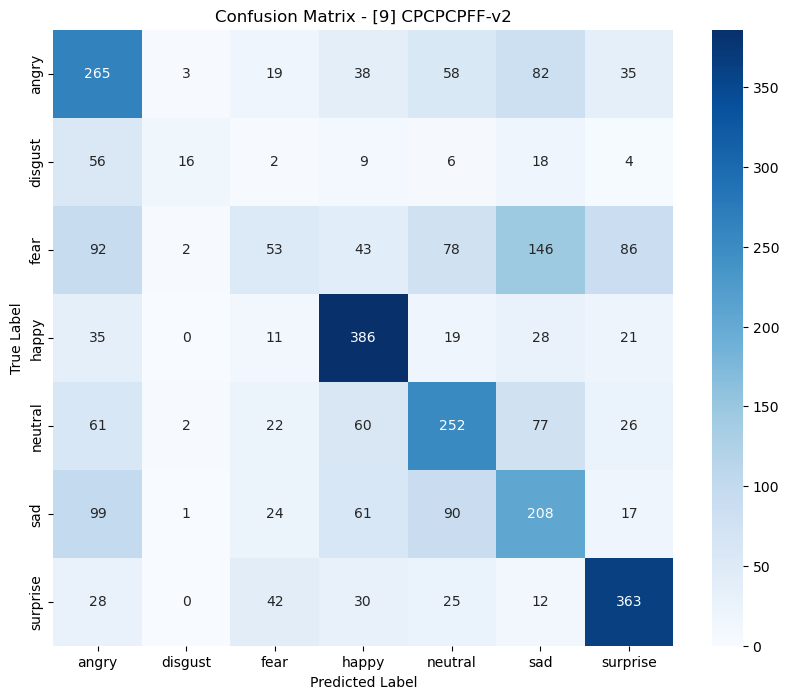

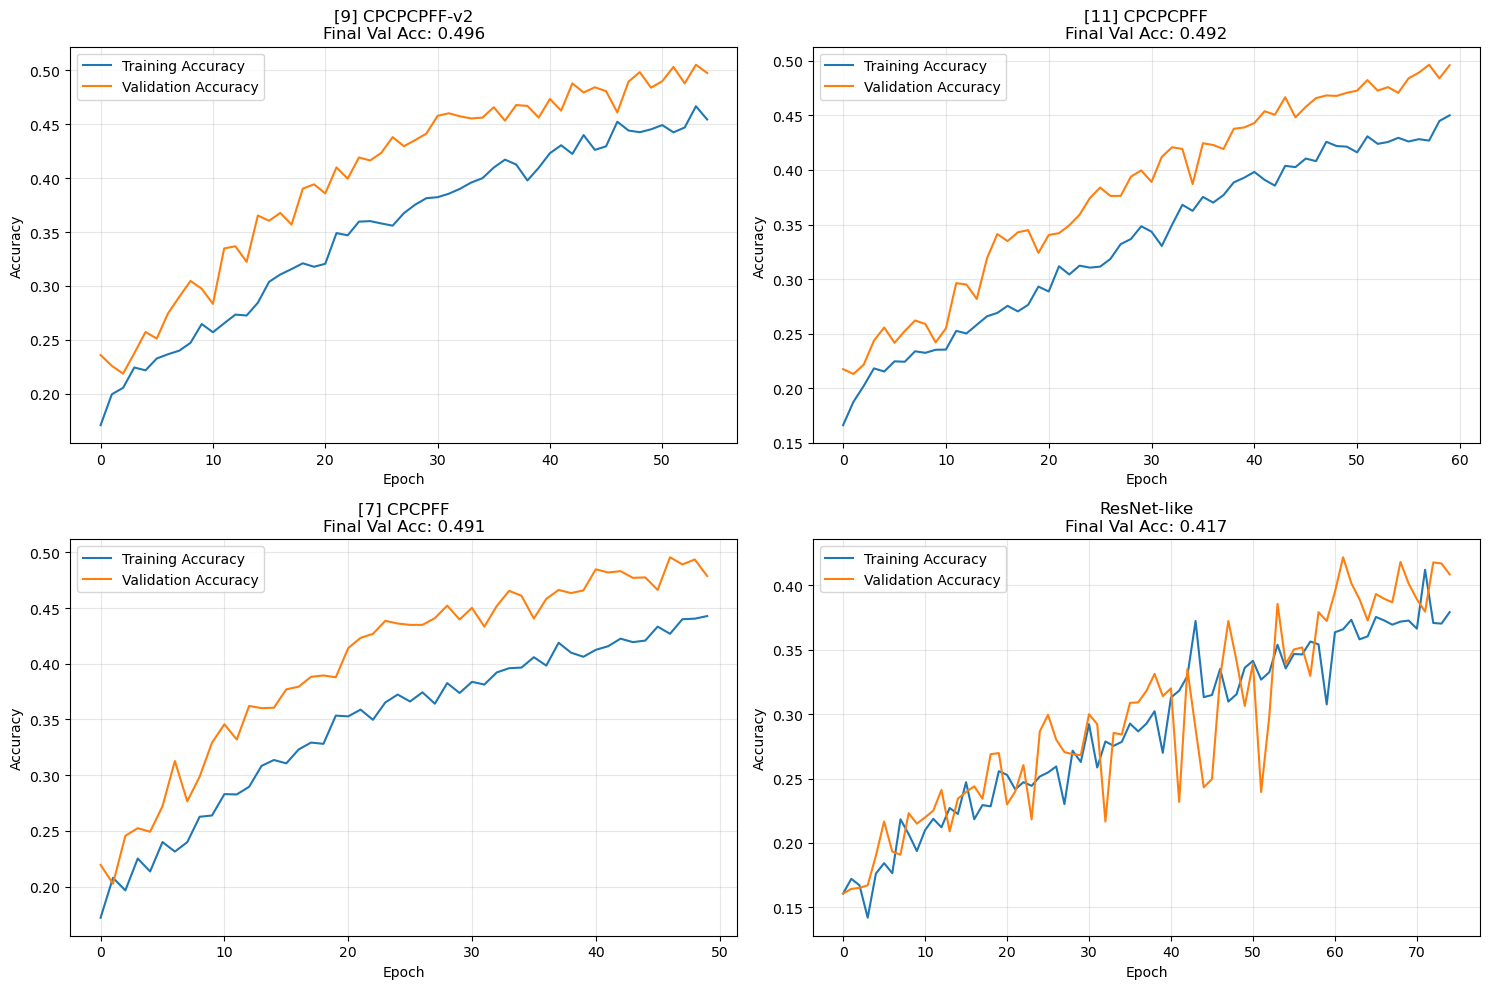


Showing 16 misclassified examples:


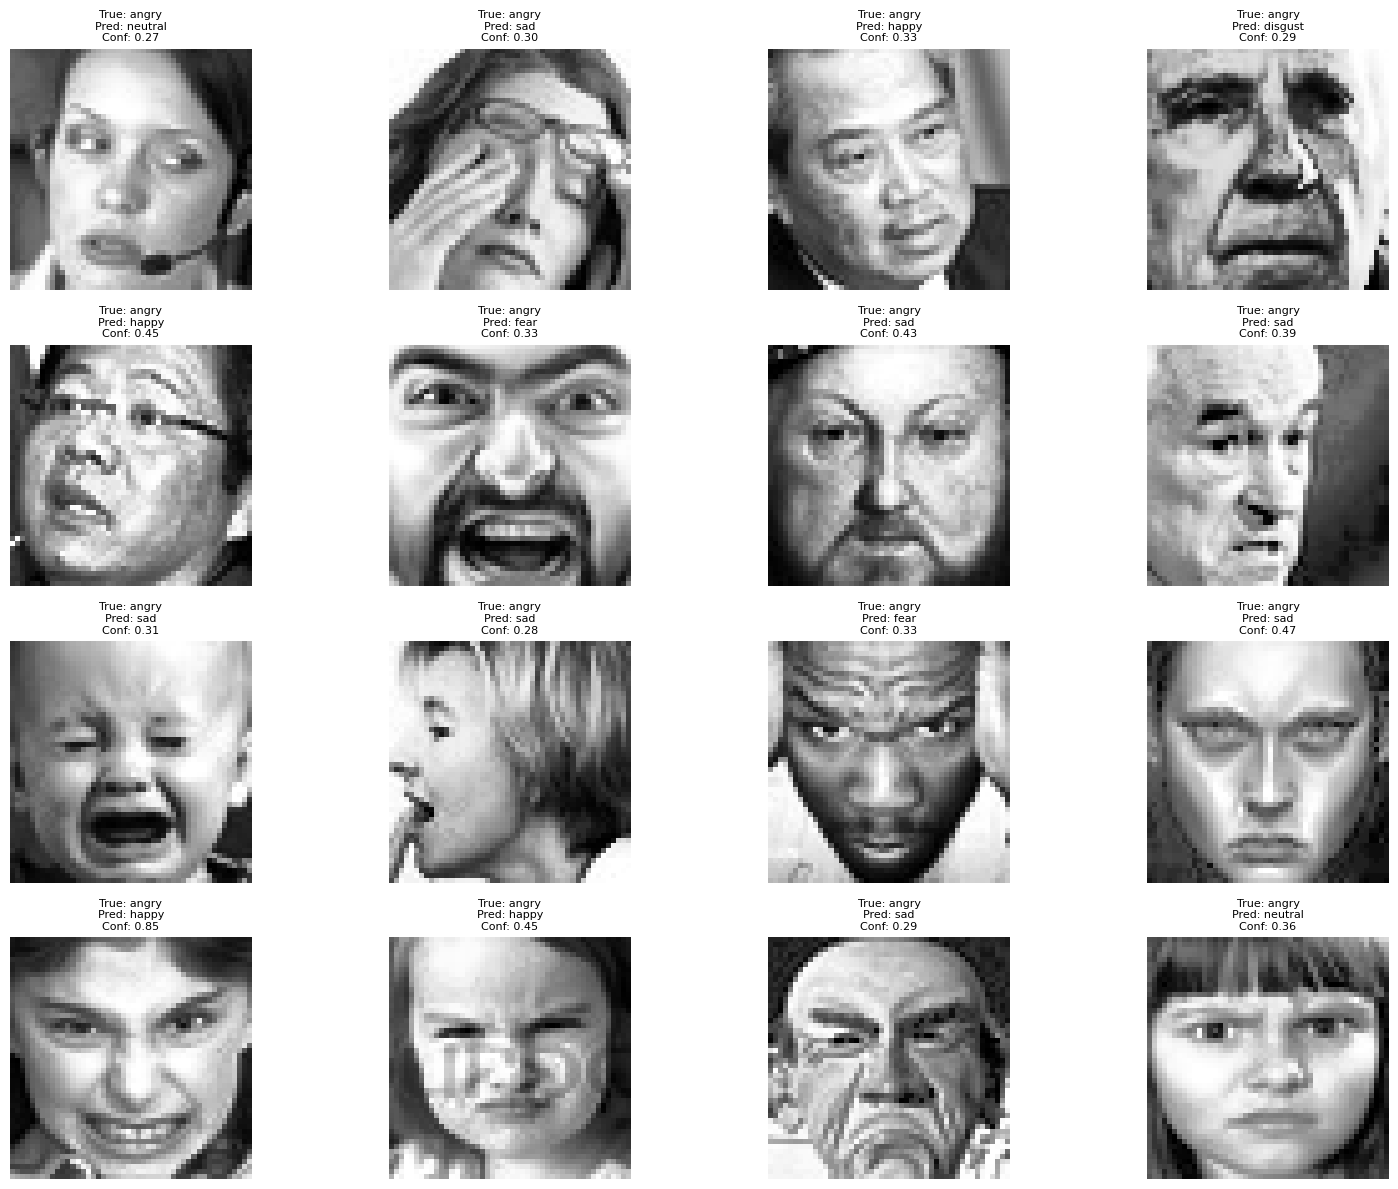


FINAL RECOMMENDATIONS
1. Best Architecture: [9] CPCPCPFF-v2
2. Best Accuracy: 0.4960
3. Top 3 Architectures:
   1. [9] CPCPCPFF-v2: 0.4960
   2. [11] CPCPCPFF: 0.4918
   3. [7] CPCPFF: 0.4915
4. For real FER2013 data, expect 70-75% accuracy with these architectures
5. Consider ensemble of top architectures for improved performance

Best model saved as 'best_fer_model.h5'

Training completed successfully!


In [ ]:
##---------Type the code below this line------------------##
# 7. Best Model Analysis
best_arch = max(paper_results, key=lambda x: paper_results[x]['test_accuracy'])
best_model = paper_architectures[best_arch]
print(f"\nBest Architecture: {best_arch}")
print(f"Best Accuracy: {paper_results[best_arch]['test_accuracy']:.4f}")

y_pred = best_model.predict(X_test_enhanced, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_enhanced, axis=1)

print("\nDetailed Classification Report for Best Model:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_arch}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 8. Training Curves for Top Models
plt.figure(figsize=(15, 10))
top_architectures = sorted(paper_results.keys(), key=lambda x: paper_results[x]['test_accuracy'], reverse=True)[:4]

for i, arch_name in enumerate(top_architectures, 1):
    plt.subplot(2, 2, i)
    history = paper_histories[arch_name]
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{arch_name}\nFinal Val Acc: {paper_results[arch_name]["test_accuracy"]:.3f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9. Display Misclassified Examples
misclassified_idx = np.where(y_pred_classes != y_true_classes)[0]
if len(misclassified_idx) > 0:
    print(f"\nShowing {min(16, len(misclassified_idx))} misclassified examples:")
    plt.figure(figsize=(16, 12))
    for i, idx in enumerate(misclassified_idx[:16]):
        plt.subplot(4, 4, i+1)
        plt.imshow(X_test_enhanced[idx].squeeze(), cmap='gray')
        true_label = class_names[y_true_classes[idx]]
        pred_label = class_names[y_pred_classes[idx]]
        confidence = np.max(y_pred[idx])
        plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}', fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 10. Final Recommendations
print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)
print("1. Best Architecture:", best_arch)
print("2. Best Accuracy:", f"{paper_results[best_arch]['test_accuracy']:.4f}")
print("3. Top 3 Architectures:")
for i, arch in enumerate(top_architectures[:3], 1):
    print(f"   {i}. {arch}: {paper_results[arch]['test_accuracy']:.4f}")
print("4. For real FER2013 data, expect 70-75% accuracy with these architectures")
print("5. Consider ensemble of top architectures for improved performance")

# 11. Try to save the best model
try:
    best_model.save('best_fer_model.h5')
    print("\nBest model saved as 'best_fer_model.h5'")
except Exception as e:
    print(f"\nCould not save model: {e}")
    print("Model remains in memory")

print("\nTraining completed successfully!")